# Amazon SageMaker Debugger - Using built-in rule

*이 노트북은 [Amazon SageMaker Debugger - Using built-in rule (영문 원본)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-debugger/tensorflow_builtin_rule/tf-mnist-builtin-rule.ipynb) 의 한국어 번역입니다.*

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) 는 머신 러닝 모델을 빌드(build), 학습(train) 및 호스팅(host)하기 위한 관리 플랫폼(managed platform)입니다. Amazon SageMaker Debugger는 거의 실시간으로 모델의 문제를 식별하고 감지하여 학습 중에 머신 러닝 모델을 디버깅할 수 있는 새로운 기능입니다.

이 노트북에서는 SageMaker built-in Rules을 사용하여 TensorFlow 프레임워크 상에서 Amazon SageMaker Debugger를 사용하는 방법을 수행해 보겠습니다.

## Amazon SageMaker Debugger는 어떻게 동작하나요?
Amazon SageMaker Debugger를 사용하면 학습 중에 loss 및 정확도(accuracy)와 같은 스칼라 값을 보는 것뿐만 아니라, 학습 중에 모든 텐서가 '그래프를 통해 흐르고 있습니다(flowing through the graph)'에 대한 완벽한 가시성(full visibility)을 제공합니다. 또한 규칙(rule)을 사용하여 거의 실시간으로 학습을 모니터링하고 학습 흐름(training flow)에 불일치가 감지되면 경고를 출력합니다.

### Concepts
* **Tensors(텐서)**: 학습 중 중간 지점(intermediate points)의 네트워크 상태를 나타냅니다.
* **Debug Hook(디버그 후크)**: Hook는 Amazon SageMaker Debugger가 학습 프로세스를 살펴보고 원하는 step 간격으로 요청된 텐서를 캡처합니다.
일부 프레임워크 컨테이너(TensorFlow 1.15, MXNet 1.6, PyTorch 1.3, XGBoost >= 0.90)들은 학습 스크립트 변경 없이 곧바로 Debugger가 활성화되며(`src/mnist_zerocodechange.py` 참조), 
다른 컨테이너의 경우 텐서 캡처 및 분석에 필요한 라이브러리 `smdebug`를 설치하고 학습 스크립트에 후크 콜백 함수를 추가하여 Debugger를 활성화할 수 있습니다(`src/mnist_byoc.py` 참조).
참고로, 본 워크샵에서는 학습 스크립트 변경이 필요 없는 TensorFlow 1.15를 사용합니다.
* **Rule(규칙)**: S3에 Hook로 캡처된 텐서를 가져와서 분석 후 이상점들(anomalies)이 발견되면 예외를 발생시키고 Amazon CloudWatch 이벤트를 트리거합니다. 여러 Rule들을 동시에 실행할 수 있습니다. 
빌트인(Built-in) Rule들은 2020년 2월 1일 기준 18개를 제공하고 있으며, 저장할 텐서/텐서 구성 방법 및 사용할 사용자 정의 Rule을 구성할 수 있는 고급 모드도 지원합니다.

상기 컨셉들을 염두에 두고 Amazon SageMaker Debugger의 전체 흐름을 이해해 보시죠.

### 학습 중 텐서 저장
디버그 후크(Debug hook)로 캡처된 텐서는 사용자가 지정한 S3 경로에 저장됩니다. 이 때, Amazon SageMaker Debugger릁 구성할 수 있는 두 가지 방법들이 있습니다.

#### 학습 스크립트 미변경 (With no changes to your training script)
Amazon SageMaker의 일부 빌트인 컨테이너들([Deep Learning Containers](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html))은 텐서를 저장하기 위해 학습 스크립트를 변경할 필요가 없습니다. Amazon SageMaker Debugger는 사용자가 지정한 방식으로 텐서를 저장하는 작업을 생성할 때, Amazon SageMaker SDK의 Tensorflow `Estimator`를 통해 제공한 설정(configuration)을 사용합니다. 
참고로, TensorFlow 프레임워크 상에서 Amazon SageMaker Debugger는 `tf.keras`, `tf.Estimator` 및 `tf.MonitoredSession` 인터페이스만 지원합니다. Debugger에 대한 자세한 설명은 [Amazon SageMaker Debugger with TensorFlow ](https://github.com/awslabs/sagemaker-debugger/tree/master/docs/tensorflow.md) 에서 확인할 수 있습니다.

#### 텐서를 저장하기 위한 스크립트 오케스트레이션 (Orchestrating your script to store tensors)
다른 컨테이너의 경우 여러분은 학습 스크립트를 몇 줄 변경해야 합니다. Amazon SageMaker Debugger는 이러한 텐서를 캡처하고 분석을 위해 저장할 수 있는 라이브러리 `smdebug`를 제공합니다. 이 라이브러리는 사용자 정의가 매우 용이하며(highly customizable), 다양한 설정 방법으로 여러분이 원하는 특정 텐서를 저장할 수 있습니다. 학습 스크립트에서 여러분이 선택한 프레임워크와 함께 Debugger 라이브러리를 사용하는 방법에 대한 자세한 내용은 [Developer Guide](https://github.com/awslabs/sagemaker-debugger/tree/master/docs)를 참조하세요. 참고로, `src/mnist_byoc` 폴더에 오케스트레이션된 예제 스크립트가 있습니다. 컨테이너에 `smdebug` 라이브러리가 설치되어 있는지 반드시 확인하세요.

### 텐서 분석

텐서가 저장되면, Amazon SageMaker Debugger에서 디버깅 규칙(***Rules***)을 실행하도록 구성할 수 있습니다. 매우 넓은 수준(very broad level)에서 규칙은 학습 중 특정 조건을 감지하는 데 사용되는 파이썬 코드입니다. 모델을 학습하는 데이터 과학자가 관심을 가질 수 있는 조건들 중 일부는 gradient가 너무 커지거나 작아지는지 모니터링하고 과적합(overfitting)을 감지하는 것입니다. Amazon Sagemaker Debugger에는 특정 퍼스트파티(1P) 규칙이 사전 패키지로 제공되며, 사용자는 Amazon Sagemaker Debugger API를 사용하여 자체 규칙을 작성할 수 있습니다. Amazon Sagemaker Debugger의 전체 API셋을 사용하여 Sagemaker 노트북과 같은 규칙 구성 외부에서 raw 텐서 데이터를 분석할 수도 있습니다. 관련 API에 대한 자세한 내용은 [Analysis Developer Guide](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md)를 참조하세요.

## Setup
Amazon SageMaker Debugger을 사용하려면 먼저 `smdebug`를 인스톨하세요. 노트북에서 대화식 분석을 수행하기 위해 필요한 라이브러리입니다.

In [3]:
!pip install --q --upgrade botocore awscli

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install --q smdebug matplotlib sagemaker

You should consider upgrading via the 'pip install --upgrade pip' command.


설정이 끝나면 Debugger가 활성화된 SageMaker에서 TensorFlow 모델 학습을 시작하세요.

## Training TensorFlow models in SageMaker with Amazon SageMaker Debugger

### SageMaker TensorFlow as a framework

Amazon Sagemaker Debugger가 활성화된 본 노트북에서 TensorFlow 모델을 학습하고 Amazon Sagemaker Debugger Rules를 사용하여 학습 작업을 모니터링합니다. 이는 Amazon SageMaker [TensorFlow 1.15.0](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html) 컨테이너를 프레임워크로 사용하여 수행됩니다.

In [10]:
import boto3
import os
import sagemaker
from sagemaker.tensorflow import TensorFlow

Amazon SageMaker Debugger 데모에 필요한 라이브러리를 가져옵니다.

In [11]:
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, rule_configs

이제 학습을 실행할 설정(configuration)을 정의하겠습니다. 학습 예제로 MNIST 데이터셋을 사용하여 이미지 인식(image recognition)을 수행해 보겠습니다.

In [13]:
PATH = '/root/sagemaker-studio-workshop-kr/debugger'

In [40]:
# define the entrypoint script
entrypoint_script='{}/src/mnist_zerocodechange.py'.format(PATH)

hyperparameters = {
    "num_epochs": 3
}

### Setting up the Estimator

이제 TensorFlow Estimator를 설정할 차례입니다. Amazon SageMaker Debugger를 통해 디버깅을 위한 학습 작업을 수행할 수 있도록 estimator에 신규 파라메터들을 추가했습니다. 신규 파라메터들은 아래와 같습니다.

* **debugger_hook_config**: 이 신규 파라메터는 텐서를 작성하려는 로컬 경로를 허용하고 텐서를 업로드할 S3 URI를 승인합니다. SageMaker는 실행 중에 이러한 텐서를 투명하게 업로드합니다.
* **rules**: 이 신규 파라메터는 이 학습 작업에서 출력된 텐서에 대해 검증하려는 규칙들의 목록을 승인합니다. 규칙의 경우 Amazon SageMaker Debugger는 두 가지 유형을 지원합니다.
 * **SageMaker Rules**: : Amazon SageMaker의 데이터 과학 및 엔지니어링 팀이 특별히 선별한 규칙으로 학습 작업에 대해 평가하도록 선택할 수 있습니다.
 * **Custom Rules**: 원하는 경우 사용자 정의 규칙(your own rule)을 Python 소스 파일로 작성하고 학습 작업과 비교하여 평가하도록 선택할 수 있습니다. 이 규칙을 평가하기 위해 Amazon SageMaker Debugger를 제공하려면 규칙 소스의 S3 위치와 평가 이미지를 제공해야 합니다.
 
#### Using Amazon SageMaker Rules
이 예시에서는 SageMaker 규칙을 사용하여 학습에 대해 평가하는 방법을 보여줍니다. 여러분은 [여기](https://github.com/awslabs/sagemaker-debugger-rulesconfig)에서 SageMaker 규칙 목록과 규칙 사용에 가장 적합한 구성을 찾을 수 있습니다.

우리가 사용할 규칙은 **VanishingGradient**와 **LossNotDecreasing**입니다. 이름에서 알 수 있듯이, 규칙은 학습 중에 디버깅 후크에 의해 캡처된 텐서에 vanishing gradients가 있는지, 그리고 loss가 감소하지 않는지 평가하려고 시도합니다.

In [47]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
bucket = 'sagemaker-studio-hol-daekeun'
prefix_for_tensors = "tensors"
 
hook_config = DebuggerHookConfig(
    s3_output_path=f"s3://{bucket}/{prefix_for_tensors}",
    collection_configs=[
        CollectionConfig("all")
    ]
)

In [ ]:
rules=[
    Rule.sagemaker(rule_configs.vanishing_gradient()), 
    Rule.sagemaker(rule_configs.loss_not_decreasing())
]

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    base_job_name='smdebugger-demo-mnist-tensorflow',
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    entry_point=entrypoint_script,
    framework_version='1.15',
    train_volume_size=400,
    py_version='py3',
    train_max_run=3600,
    script_mode=True,
    hyperparameters=hyperparameters,
    ## New parameter
    rules = rules
)

In [49]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()), 
    Rule.sagemaker(rule_configs.loss_not_decreasing())
]

estimator = TensorFlow(
    role=sagemaker.get_execution_role(),
    base_job_name='smdebugger-demo-mnist-tensorflow',
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    train_volume_size=400,
    entry_point=entrypoint_script,
    framework_version='1.15',
    py_version='py3',
    train_max_run=3600,
    script_mode=True,
    hyperparameters=hyperparameters,
    ## New parameters    
    debugger_hook_config=hook_config,
    rules = rules
)

*Amazon Sagemaker Debugger는 현재 py_version='py3'에 대해서만 지원됩니다.*

TensorFlow Estimator에서 `fit()`을 호출하여 학습을 시작하겠습니다.

In [50]:
estimator.fit(wait=True)

2020-01-25 13:56:20 Starting - Starting the training job...
2020-01-25 13:56:22 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  VanishingGradient: InProgress        
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-01-25 13:57:48 Starting - Preparing the instances for training...
2020-01-25 13:58:18 Downloading - Downloading input data...
2020-01-25 13:58:48 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1467: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-01-25 13:58:50,963 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-01-25 13:58:50,969 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-25 13:58:51,220 sagemaker-containers INFO     No GPUs detected (norm

## Result 

`fit()`을 호출한 결과, Amazon SageMaker Debugger는 학습 작업과 병행하여 vanishing gradient 및 loss 감소를 모니터링하기 위해 두 가지 규칙 평가 작업(rule evaluation job)을 시작했습니다. 규칙 평가 상태는 정기적으로 학습 로그에 표시됩니다.

In [57]:
for d in estimator.latest_training_job.rule_job_summary():
    print(f"{d['RuleConfigurationName']}: {d['RuleEvaluationStatus']}")

VanishingGradient: NoIssuesFound
LossNotDecreasing: InProgress


In [53]:
from smdebug.trials import create_trial
trial = create_trial(path=estimator.latest_job_debugger_artifacts_path())

[2020-01-25 14:02:24.769 d2ce398a4188:301 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-hol-daekeun/tensors/smdebugger-demo-mnist-tensorflow-2020-01-25-13-56-19-666/debug-output


In [54]:
trial.tensor_names()

[2020-01-25 14:02:48.344 d2ce398a4188:301 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2020-01-25 14:02:49.362 d2ce398a4188:301 INFO trial.py:209] Loaded all steps


['conv2d/bias:0',
 'conv2d/kernel:0',
 'conv2d_1/bias:0',
 'conv2d_1/kernel:0',
 'dense/bias:0',
 'dense/kernel:0',
 'dense_1/bias:0',
 'dense_1/kernel:0',
 'gradients/conv2d/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/dense/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense/MatMul_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/MatMul_grad/tuple/control_dependency_1:0',
 'sparse_softmax_cross_entropy_loss/value:0']

In [46]:
print(f"logdir = \"s3://{bucket}/{prefix_for_tensorboard}/\"")

logdir = "s3://sagemaker-studio-hol-daekeun/tb_log/"


In [29]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:143656149352:processing-job/smdebugger-demo-mnist-tens-vanishinggradient-f1d96010',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 1, 25, 13, 32, 16, 61000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:143656149352:processing-job/smdebugger-demo-mnist-tens-lossnotdecreasing-b17034ab',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2020, 1, 25, 13, 32, 16, 61000, tzinfo=tzlocal())}]

감소하지 않는 loss에 대해 규칙 작업의 로그를 살펴 보도록 하겠습니다. 이를 위해 아래 utlity 함수들을 사용하여 규칙 작업 로그에 대한 링크를 가져옵니다.

In [33]:
def _get_rule_job_name(training_job_name, rule_configuration_name, rule_job_arn):
        """Helper function to get the rule job name with correct casing"""
        return "{}-{}-{}".format(
            training_job_name[:26], rule_configuration_name[:26], rule_job_arn[-8:]
        )
    
def _get_cw_url_for_rule_job(rule_job_name, region):
    return "https://{}.console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix".format(region, region, rule_job_name)


def get_rule_jobs_cw_urls(estimator):
    region = boto3.Session().region_name
    training_job = estimator.latest_training_job
    training_job_name = training_job.describe()["TrainingJobName"]
    rule_eval_statuses = training_job.describe()["DebugRuleEvaluationStatuses"]
    
    result={}
    for status in rule_eval_statuses:
        if status.get("RuleEvaluationJobArn", None) is not None:
            rule_job_name = _get_rule_job_name(training_job_name, status["RuleConfigurationName"], status["RuleEvaluationJobArn"])
            result[status["RuleConfigurationName"]] = _get_cw_url_for_rule_job(rule_job_name, region)
    return result

get_rule_jobs_cw_urls(estimator)

{'VanishingGradient': 'https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-VanishingGradient-f1d96010;streamFilter=typeLogStreamPrefix',
 'LossNotDecreasing': 'https://us-east-2.console.aws.amazon.com/cloudwatch/home?region=us-east-2#logStream:group=/aws/sagemaker/ProcessingJobs;prefix=smdebugger-demo-mnist-tens-LossNotDecreasing-b17034ab;streamFilter=typeLogStreamPrefix'}

## Data Analysis - Interactive Exploration

학습을 수행하고 규칙을 통한 자동 분석을 살펴 보았으므로, Amazon SageMaker Debugger의 다른 측면도 살펴 보겠습니다. 실시간 또는 작업 후 저장된 텐서의 대화식 탐색(interactive exploration)을 수행할 수 있습니다. 여기서 우리는 위 작업의 사후 분석(after-the-fact analysis)에 중점을 두며, 이를 위해 `smdebug` 라이브러리를 가져오겠습니다. 이 라이브러리는 단일 학습 실행을 나타내는 Trial의 개념을 정의합니다. 위 작업에 대한 Debugger 아티팩트 경로를 가져 오는 방법에 유의하세요.

In [34]:
from smdebug.trials import create_trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2020-01-25 13:33:40.214 d2ce398a4188:301 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-143656149352/smdebugger-demo-mnist-tensorflow-2020-01-25-13-25-07-406/debug-output


여러분은 plot하고 싶은 것을 알기 위해 기록된 모든 텐서를 나열할 수 있습니다. 이 이름들 각각은 TensorFlow에 의해 자동 할당되는 텐서의 이름입니다. 이러한 이름을 사용할 수 없는 일부 프레임워크에서는 레이어 이름과 가중치(weights), 그래디언트(gradients), 바이어스(biases), 입력 또는 출력 여부에 따라 이름을 생성합니다.

In [35]:
trial.tensor_names()

[2020-01-25 13:33:41.722 d2ce398a4188:301 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2020-01-25 13:33:42.740 d2ce398a4188:301 INFO trial.py:209] Loaded all steps


['gradients/conv2d/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/conv2d_1/Conv2D_grad/tuple/control_dependency_1:0',
 'gradients/dense/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense/MatMul_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0',
 'gradients/dense_1/MatMul_grad/tuple/control_dependency_1:0',
 'sparse_softmax_cross_entropy_loss/value:0']

또한, `smdebug`가 학습 작업에서 생성하는 일부 기본 컬렉션으로 텐서를 검색할 수도 있습니다. 여기서 우리는 loss 컬렉션에 관심이 있으므로 다음과 같이 loss 컬렉션 텐서 이름을 검색할 수 있습니다. Amazon SageMaker Debugger는 가중치(weights), 그래디언트(gradients), 바이어스(biases), loss과 같은 기본 컬렉션을 자동으로 생성합니다. 텐서에서 사용자 정의 컬렉션들(custom collections)을 생성할 수도 있습니다.

In [36]:
trial.tensor_names(collection="losses")

['sparse_softmax_cross_entropy_loss/value:0']

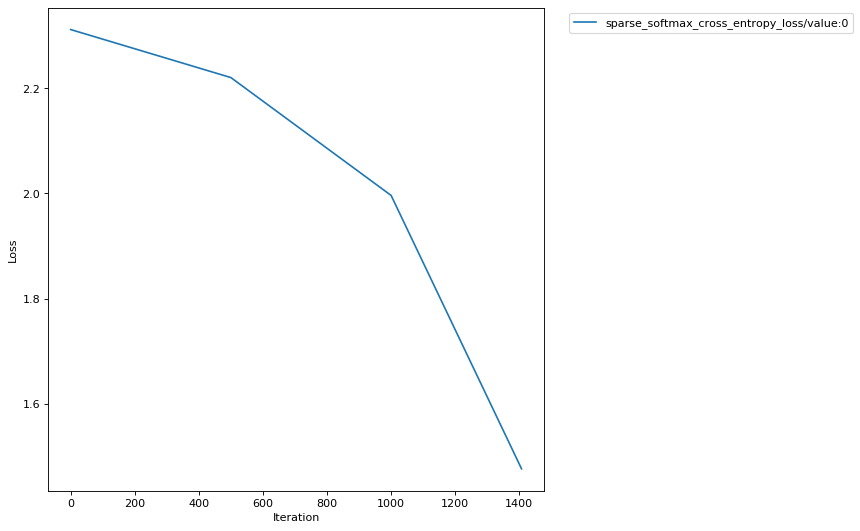

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import re

# Define a function that, for the given tensor name, walks through all 
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_tensors(trial, collection_name, ylabel=''):
    """
    Takes a `trial` and plots all tensors that match the given regex.
    """
    plt.figure(
        num=1, figsize=(8, 8), dpi=80,
        facecolor='w', edgecolor='k')

    tensors = trial.tensor_names(collection=collection_name)

    for tensor_name in sorted(tensors):
        steps, data = get_data(trial, tensor_name)
        plt.plot(steps, data, label=tensor_name)

    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.show()
    
plot_tensors(trial, "losses", ylabel="Loss")